# Generative Radio Channel with Synthetic Data

This notebook serves as the synthetic dataset generation. I try to create 1000 samples. 800 for training, 100 for validation, and 100 for testing. A sample room is provided as an SVG made with Inkscape. I did this so that I have something to work with when exploring FSPL and Multi-Wall models. Also so that we can arbitrarily create rooms using Inkscape, save to SVG, and try out our glorious model.

Based on COST INTERACT paper

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/ai_in_wireless`


In [2]:
using Plots
using Printf: @printf, @sprintf

In [3]:
include("map.jl")
include("signals.jl")

multiwall_heatmap (generic function with 1 method)

Suppose that we have three transmitter locations:
1. $(20.0, 30.0)$
2. $(4.0, 9.0)$
3. $(98.0, 78.0)$

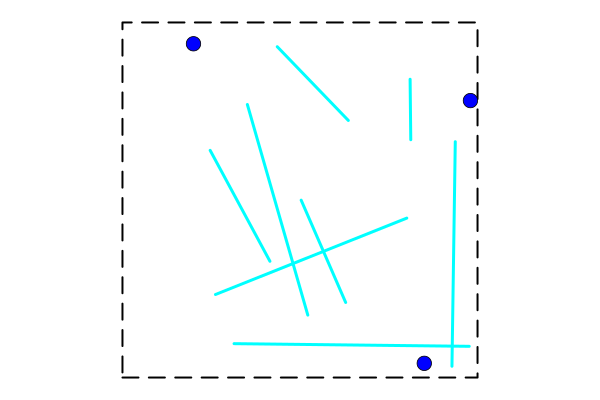

In [4]:
transmitters = Point{2, Float32}[
    Point2f(20.0, 94.0),
    Point2f(85.0, 4.0),
    Point2f(98.0, 78.0),
]

room = loadroom("map1.svg"; transmitters = transmitters)
p = plotroom(room)

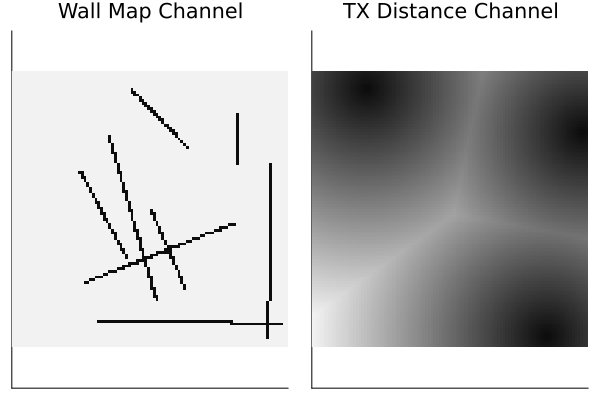

In [5]:
rs = rasterize(room)
rs_plot1 = heatmap(abs.(1 .- rs[:, :, 1])', 
    c = :grays, 
    aspect_ratio = :equal, 
    title = "Wall Map Channel",
    axis=nothing,
    ticks=nothing,
    legend=nothing,
)

rs_plot2 = heatmap(rs[:,:,2]', 
    c = :grays, 
    aspect_ratio = :equal, 
    title = "TX Distance Channel",
    axis=nothing,
    ticks=nothing,
    legend=nothing,
)

plot(rs_plot1, rs_plot2)

### Free Space Path Loss

Let the receiver be $R = (x_r, y_r)$ and transmitters be $T_i = (x_i, y_i)$. 

The euclidean distance from the receiver to each transmitter $i$ is
$$
d_i = \sqrt{(x_r - x_i)^2 + (y_r - y_i)^2}
$$

So the FSPL (from lecture slides) for each transmitter is
$$
L_{i,\text{dB}} = 20\log_{10} f + 20\log_{10} d + 32.45
$$
where $f$ is the signal frequency in Gigahertz

In [6]:
rx = Point2f(30.0f0, 56.0f0)
fspl(Point2f(20.0f0, 94.0f0), rx)

79.75351257324219

In [7]:
fspl(room, rx)

3-element Vector{Float64}:
 79.75351257324219
 85.44782943725586
 84.94955368041992

In [8]:
hmap = fspl_map(room)

100×100×3 Array{Float32, 3}:
[:, :, 1] =
 87.4143  87.3242  87.2332  87.1413  …  73.5491  73.6305  73.7329  73.8549
 87.3964  87.3059  87.2145  87.1222     73.0915  73.1818  73.2953  73.4301
 87.3794  87.2886  87.1968  87.1041     72.6092  72.71    72.8363  72.9859
 87.3634  87.2722  87.1801  87.087      72.0995  72.2127  72.3541  72.5209
 87.3482  87.2567  87.1643  87.0709     71.5592  71.6872  71.8464  72.0334
 87.334   87.2422  87.1495  87.0557  …  70.9846  71.1304  71.311   71.5219
 87.3207  87.2287  87.1356  87.0416     70.3712  70.5388  70.7451  70.9846
 87.3084  87.2161  87.1227  87.0284     69.714   69.9082  70.1459  70.4198
 87.297   87.2044  87.1109  87.0163     69.0065  69.2342  69.5106  69.826
 87.2866  87.1938  87.1     87.0052     68.2413  68.5116  68.8361  69.2024
 87.2772  87.1842  87.0901  86.9951  …  67.4095  67.7348  68.1201  68.5489
 87.2687  87.1755  87.0813  86.9861     66.5003  66.8979  67.3609  67.867
 87.2612  87.1679  87.0735  86.9781     65.5013  65.9962  66.

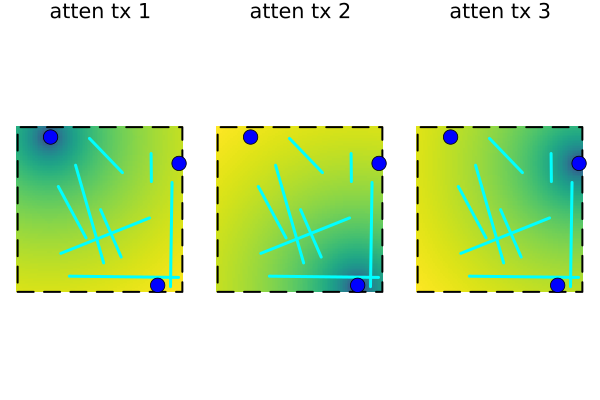

In [9]:
heatmap_plots = [
    plot_discrete_heatmap(room, hmap[:, :, i]; title = @sprintf("atten tx %d", i))
    for i ∈ 1:length(room.transmitters)
]

plot(heatmap_plots..., layout=(1, 3))

Heatmap when considering which TX is used by the RX based on attenuation

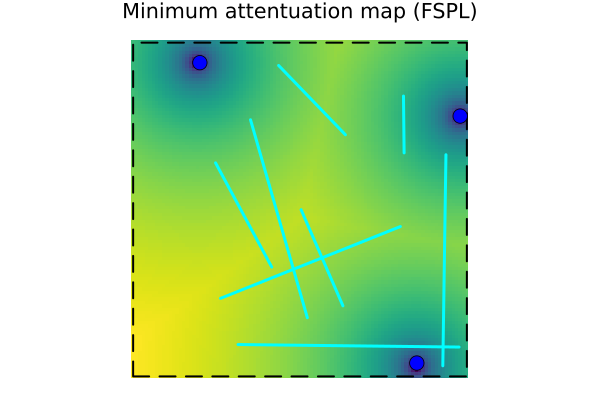

In [10]:
plot_discrete_heatmap(room, minimum(hmap, dims=3)[:, :, 1]; title="Minimum attentuation map (FSPL)")

### Multi-Wall Model

**Source**: https://thesai.org/Downloads/Volume12No4/Paper_94-Integrating_Cost_231_Multiwall_Propagation.pdf

To create the ground truth for the model, we make use of [Multi-Wall Model](https://thesai.org/Downloads/Volume12No4/Paper_94-Integrating_Cost_231_Multiwall_Propagation.pdf). This considers obstacles around the transmitter.

$$
L_{MW} = L_{FSL}(d) + \sum_{i=1}^N k_{wi}L_{wi} + k_fL_f
$$

where
* $L_{FSL}(d)$ - FSPL dependent on the distance $d$ and frequency $f$ (Given above)
* $N$ - Total number of different wall types
* $k_{wi}$ - number of walls of type $i$ that the direct signal path intersects.
* $L_{wi}$ - Attenuation factor (loss in dB) for a wall of type $i$
* $k_fL_f$ - Loss due floors due to multiple levels.

Since we only have 2D environment, then $k_fL_f=0$. Furthermore, suppose that all walls are concrete walls. The Cost 231 paper says that the attenuation for this type of wall will be 12 dB (assuming frequency of 2.4 GHz).

This greatly simplifies our multi-wall function to:

$$
L_{i,MW} = L_{i,\text{dB}}(d) + 12k
$$

where $k$ is the number of walls that intersects the ray between the TX and the RX.

In [11]:
count_walls(room, Point2f(50.0, 50.0))

3-element Vector{Int64}:
 1
 3
 1

In [12]:
mw_hmap = multiwall_heatmap(room; σ=3.0)

100×100×3 Array{Float32, 3}:
[:, :, 1] =
  85.9398   87.7424   90.2585  …  75.9782  78.8025  78.4876  75.3648
  88.0969   91.3965   85.5335     74.1698  74.1117  75.0846  73.6615
  86.0033   90.7281   84.3565     67.7784  72.5226  75.0944  72.531
  89.6163   85.1316   85.7051     76.0743  68.4481  71.9869  67.2888
  86.0449   88.1537   92.6321     71.8959  74.0276  73.1715  70.3251
  84.6337   91.46     88.876   …  74.4286  71.8325  69.183   70.2408
  85.0238   84.1741   96.4872     69.6646  69.831   64.5325  64.3968
  87.7169   83.6658   89.156      70.4222  72.3503  73.633   71.0729
  87.0383   84.7604   85.1488     71.0726  68.0532  63.598   70.1819
  82.4334   88.1924   87.3533     70.6046  65.5665  71.4607  71.2144
  87.9422   86.8054   83.5093  …  67.3732  63.7958  67.7314  70.8293
  85.3565   84.9329   87.0995     65.5408  70.3003  68.8219  64.9892
  84.0576   90.8832   94.2935     63.2134  66.619   65.2544  63.8438
   ⋮                           ⋱                             
 

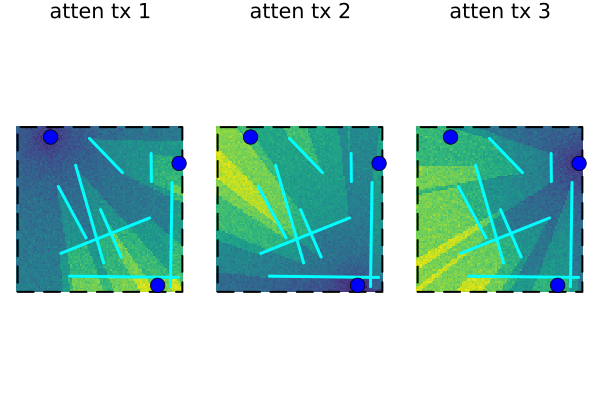

In [13]:
heatmap_plots = [
    plot_discrete_heatmap(room, mw_hmap[:, :, i]; title = @sprintf("atten tx %d", i))
    for i ∈ 1:length(room.transmitters)
]

plot(heatmap_plots..., layout=(1, 3))

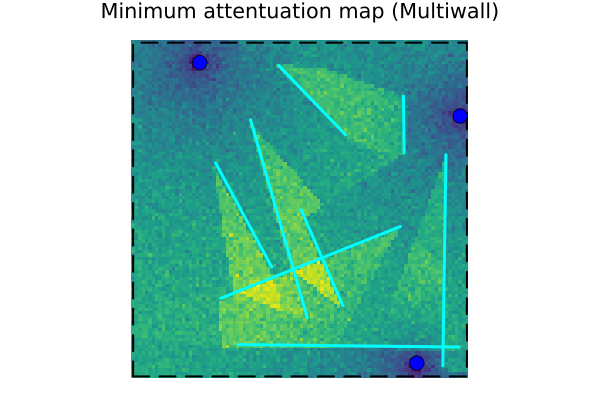

In [14]:
plot_discrete_heatmap(room, minimum(mw_hmap, dims=3)[:, :, 1]; title="Minimum attentuation map (Multiwall)")

### Generation

In [15]:
trainset = [
    generate_random_room(; dim=100f0, num_walls=10, num_tx=3) for _ ∈ 1:9000
]
valset = [
    generate_random_room(; dim=100f0, num_walls=10, num_tx=3) for _ ∈ 1:500
]
testset = [
    generate_random_room(; dim=100f0, num_walls=10, num_tx=3) for _ ∈ 1:500
];

Random rooms in the training set

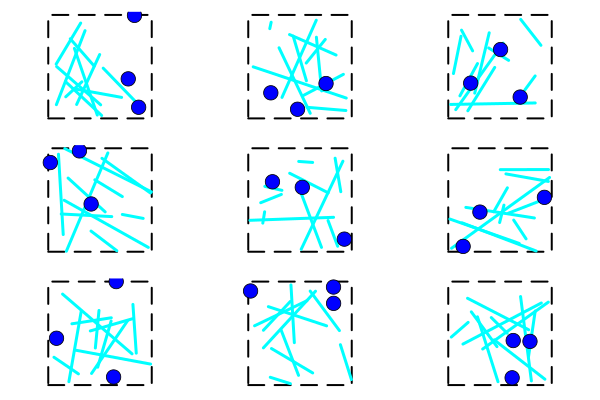

In [16]:
rs = plotroom.(trainset[1:9])

plot(rs..., layout=(3, 3))

Save these to some file so we don't have to lose the generated dataset

In [17]:
using Serialization: serialize, deserialize

In [18]:
serialize("dataset/trainset.dat", trainset)
serialize("dataset/valset.dat", valset)
serialize("dataset/testset.dat", testset)

But we want easier access for training so we convert this into the raster maps and the ground truth.

In [19]:
using Base.Threads: @threads # For faster processing
using ProgressMeter

In [21]:
σ = 3.0f0

function rasterized_set(set; W = 100, H = 100)
    N = length(set)
    # (100, 100, 2 channels, dataset size)
    features = Array{Float32}(undef, W, H, 2, N)
    ground_truth = Array{Float32}(undef, W, H, 3, N)

    p = Progress(N; dt=1.0, desc="Generating Dataset...")

    @threads for i ∈ 1:N
        room = set[i]
        features[:, :, :, i] .= rasterize(room)
        hm = multiwall_heatmap(room; σ=3.0f0)
        ground_truth[:, :, :, i] .= hm
        next!(p)
    end
    features, ground_truth
end

rasterized_set (generic function with 1 method)

In [26]:
X_train, y_train = rasterized_set(trainset)
size(X_train), size(y_train)

Generating Dataset... 100%|██████████████████████████████| Time: 0:01:55


((100, 100, 2, 9000), (100, 100, 3, 9000))

In [24]:
X_val, y_val = rasterized_set(valset)
size(X_val), size(y_val)

Generating Dataset... 100%|██████████████████████████████| Time: 0:00:06


((100, 100, 2, 500), (100, 100, 3, 500))

In [25]:
X_test, y_test = rasterized_set(testset)
size(X_test), size(y_test)

Generating Dataset... 100%|██████████████████████████████| Time: 0:00:06


((100, 100, 2, 500), (100, 100, 3, 500))

Serialize all these preprocessed dataset.

In [27]:
serialize("dataset/X_train.dat", X_train)
serialize("dataset/y_train.data", y_train)

serialize("dataset/X_val.dat", X_val)
serialize("dataset/y_val.data", y_val)

serialize("dataset/X_test.dat", X_test)
serialize("dataset/y_test.data", y_test)

60000000

In [30]:
run(`ls -lh dataset`)

total 1.9G
-rw-r--r-- 1 s207399 Domain Users 103K Jan 15 01:03 testset.dat
-rw-r--r-- 1 s207399 Domain Users 1.9M Jan 15 01:03 trainset.dat
-rw-r--r-- 1 s207399 Domain Users 103K Jan 15 01:03 valset.dat
-rw-r--r-- 1 s207399 Domain Users  39M Jan 15 01:06 X_test.dat
-rw-r--r-- 1 s207399 Domain Users 687M Jan 15 01:06 X_train.dat
-rw-r--r-- 1 s207399 Domain Users  39M Jan 15 01:06 X_val.dat
-rw-r--r-- 1 s207399 Domain Users  58M Jan 15 01:06 y_test.data
-rw-r--r-- 1 s207399 Domain Users 1.1G Jan 15 01:06 y_train.data
-rw-r--r-- 1 s207399 Domain Users  58M Jan 15 01:06 y_val.data


Process(`ls -lh dataset`, ProcessExited(0))